### Information on our system

In [1]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')
print(sys.version)

3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]


### Installing requirements to download packages 

In [2]:
!pip install -r requirements.txt;

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt;'
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Reproductible Results

In [3]:
from numpy.random import seed
seed(1337)
import tensorflow
tensorflow.random.set_seed(1337)

### Import necessited packages

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Path

In [5]:
path = r'~/Desktop/NN/'

### Functions 

In [8]:
def acc_loss(nn_it):
    plt.style.use('ggplot')
    
    acc = nn_it.history['acc']
    val_acc = nn_it.history['val_acc']
    loss = nn_it.history['loss']
    val_loss = nn_it.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def check_stratify(y_train, y_test):
    if np.count_nonzero(y_test)/len(y_test) == np.count_nonzero(y_train)/len(y_train):
        print("We are good to go ! train_test_split well stratified: {} for y_test and {} for y_train".format(np.count_nonzero(y_test)/len(y_test), np.count_nonzero(y_train)/len(y_train)))
    else:
        print("train_test_split not well stratified: {} for y_test and {} for y_train".format(np.count_nonzero(y_test)/len(y_test), np.count_nonzero(y_train)/len(y_train)))

### Pre-Process

In [9]:
df = pd.read_csv(os.path.join(path,"credit_scoring.csv"))


df = df.rename(columns = {'Unnamed: 0':'Client_ID'})
df = df.drop(columns = ['Client_ID'])
df.loc[df.Cible == 1, 'Cible'] = 0
df.loc[df.Cible == 2, 'Cible'] = 1

for col in ['Comptes', 'Historique_credit', 'Objet_credit', 'Epargne', 'Anciennete_emploi', 'Situation_familiale', 'Garanties', 'Biens', 'Autres_credits', 'Statut_domicile', 'Type_emploi', 'Telephone', 'Etranger']:
    df[col] = df[col].astype('category')
    
labels = df['Cible'].values
features = pd.get_dummies(df)
features = features.drop(columns = ['Cible'])
features_list = list(features.columns)

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test_size, random_state=1337, stratify = labels)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

### Parameters

In [10]:
# For the Pre-Process
test_size = 0.30

# For Keras Models
input_dim = X_train.shape[1]

The idea here is to check if the sokut between the train and test set is indeed stratified

In [11]:
check_stratify(y_train, y_test)

We are good to go ! train_test_split well stratified: 0.3 for y_test and 0.3 for y_train


# Multi-Layers Perceptron

### Using the MLPClassifier from sklearn
* **hiden_layer_sizes**: The ith element represents the number of neurons in the ith hidden layer.
* **alpha**: L2 penalty (regularization term) parameter.

In [7]:
tuned_parameters = {'hidden_layer_sizes':[(5,2), (20,2), (50,2), (100,2), (150,2), (200,2)],
                    'alpha':   [0.001, 0.01, 1, 2]}

In [23]:
clf = GridSearchCV(MLPClassifier(), tuned_parameters, cv=5, verbose = True, n_jobs = -1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [24]:
print(clf.best_params_)

{'alpha': 2, 'hidden_layer_sizes': (200, 2)}


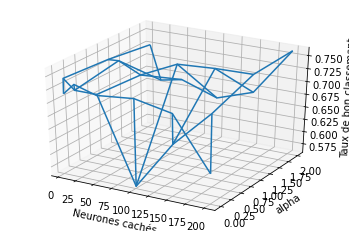

In [25]:
n_hidden = np.array([5, 20, 50, 100, 150, 200])
alphas = np.array([0.001, 0.01, 1, 2])
# les coordonnées des points de la grille sont les valeurs des hyperparamètres (tuned_parameters)
xx, yy = np.meshgrid(n_hidden, alphas)
Z = clf.cv_results_['mean_test_score'].reshape(xx.shape)

# affichage sous forme de wireframe des résultats des modèles évalués

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("Neurones cachés")
ax.set_ylabel("alpha")
ax.set_zlabel("Taux de bon classement")
ax.plot_wireframe(xx, yy, Z)

In [26]:
clf.score(X_test, y_test)

0.6966666666666667

In [29]:
tuned_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [13]:
predictions = clf.predict(X_test)

In [15]:

c = confusion_matrix(y_test,predictions)
print(classification_report(y_test,predictions))

NameError: name 'predictions' is not defined

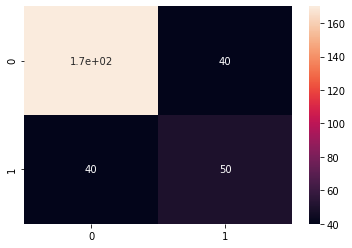

In [18]:

sns.heatmap(c, annot=True)

In [9]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [10]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [11]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose = True)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   13.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],


In [12]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.720 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.751 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.737 (+/-0.040) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.733 (+/-0.029) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.751 (+/-0.031) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.744 (+/-0.022) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver'

In [92]:
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       210
           1       0.53      0.46      0.49        90

    accuracy                           0.71       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.70      0.71      0.71       300



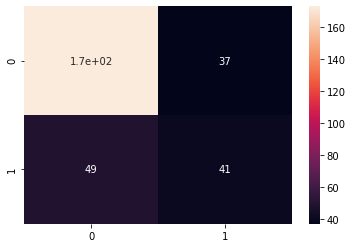

In [16]:
c = confusion_matrix(y_true,y_pred)
import seaborn as sns
sns.heatmap(c, annot=True)

### Using Keras
* **kernal_initializer**: The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.
* **activation**: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: $a(x) = x$).

The idea is to create a Model using Keras **add.layer**.  
For example here we have:
* An input layer equals to the number of features we have after one hot encoding (input_dim = 61),
* 1-th hidden layer that has 256 hidden neurons, with a rectified linear unit (ReLU) as activation function,
* An output layer with 1 hidden neurons, with a sigmoid as activation function.


In [27]:
def Keras_Model():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(units = 256,
                  kernel_initializer = 'uniform',
                  activation = 'relu',
                  input_dim = input_dim)(inputs)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

We instantiate our first Keras model to make **classifier**. 
We then compile our model using the following argument:
* **loss = 'binary_crossentropy'** : As part of the optimization algorithm, the error for the current state of the model must be estimated repeatedly. This requires the choice of an error function, conventionally called a loss function, that can be used to estimate the loss of the model so that the weights can be updated to reduce the loss on the next evaluation. As we are dealing with a classification problem, binary_crossentropy is the function we want to chose.
* **optimizer = 'adam'**: It seems the [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/) optimizer nearly always works better (faster and more reliably reaching a global minimum) when minimising the cost function in training neural nets. This is why we will not even bother trying another one.
* **metrics = 'acc'**: Obviously we want to maximize accuracy.

In [28]:
classifier = Keras_Model()
classifier.compile(loss = 'binary_crossentropy',
                   optimizer = 'adam',
                   metrics = ['mse', 'acc'])

It is about time to fit our model:
* **validation_split = 0.20**: arbitrary choice of a validation set.
* **batch_size = 32**: The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient. In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
* **epochs = 20**: The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm. You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples. In our case, epoch does not really matter as we use early stopping.
* **EarlyStopping**: Stop training when a monitored quantity has stopped improving. Here the monitored quantity is validation loss in order to avoid overfitting. **min_delta** correspond to minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

In [29]:
nn_it = classifier.fit(X_train, y_train,
                       validation_split=0.20,
                       batch_size = 100,
                       epochs = 20,
                       callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)])


Train on 560 samples, validate on 140 samples
Epoch 1/20
560/560 [==============================] - 0s 360us/step - loss: 0.6401 - mse: 0.2239 - acc: 0.6750 - val_loss: 0.6083 - val_mse: 0.2092 - val_acc: 0.6786
Epoch 2/20
560/560 [==============================] - 0s 20us/step - loss: 0.5252 - mse: 0.1710 - acc: 0.7964 - val_loss: 0.5736 - val_mse: 0.1949 - val_acc: 0.7143
Epoch 3/20
560/560 [==============================] - 0s 21us/step - loss: 0.4648 - mse: 0.1474 - acc: 0.7946 - val_loss: 0.5584 - val_mse: 0.1897 - val_acc: 0.7214
Epoch 4/20
560/560 [==============================] - 0s 20us/step - loss: 0.4251 - mse: 0.1338 - acc: 0.8143 - val_loss: 0.5523 - val_mse: 0.1877 - val_acc: 0.7143
Epoch 5/20
560/560 [==============================] - 0s 21us/step - loss: 0.4003 - mse: 0.1256 - acc: 0.8214 - val_loss: 0.5503 - val_mse: 0.1866 - val_acc: 0.6929
Epoch 6/20
560/560 [==============================] - 0s 25us/step - loss: 0.3804 - mse: 0.1192 - acc: 0.8214 - val_loss: 0.5483

Prediction then computing the confusion matrix

[[177  33]
 [ 50  40]]


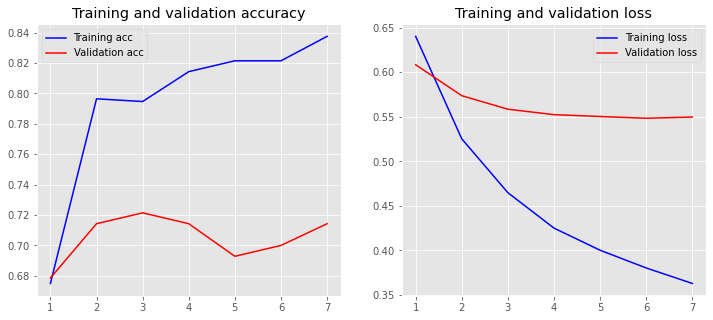

In [30]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


acc_loss(nn_it)

In [31]:
loss, mse, accuracy = classifier.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, mse, accuracy = classifier.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8171
Testing Accuracy:  0.7233


Train on 595 samples, validate on 105 samples
Epoch 1/100
595/595 [==============================] - 0s 375us/step - loss: 0.6737 - mse: 0.2403 - acc: 0.6034 - val_loss: 0.6432 - val_mse: 0.2253 - val_acc: 0.7429
Epoch 2/100
595/595 [==============================] - 0s 37us/step - loss: 0.6244 - mse: 0.2162 - acc: 0.7395 - val_loss: 0.6058 - val_mse: 0.2075 - val_acc: 0.7619
Epoch 3/100
595/595 [==============================] - 0s 39us/step - loss: 0.5839 - mse: 0.1973 - acc: 0.7697 - val_loss: 0.5734 - val_mse: 0.1931 - val_acc: 0.7619
Epoch 4/100
595/595 [==============================] - 0s 39us/step - loss: 0.5502 - mse: 0.1827 - acc: 0.7613 - val_loss: 0.5478 - val_mse: 0.1827 - val_acc: 0.7333
Epoch 5/100
595/595 [==============================] - 0s 48us/step - loss: 0.5228 - mse: 0.1717 - acc: 0.7731 - val_loss: 0.5275 - val_mse: 0.1749 - val_acc: 0.7333
Epoch 6/100
595/595 [==============================] - 0s 40us/step - loss: 0.5017 - mse: 0.1636 - acc: 0.7798 - val_loss: 

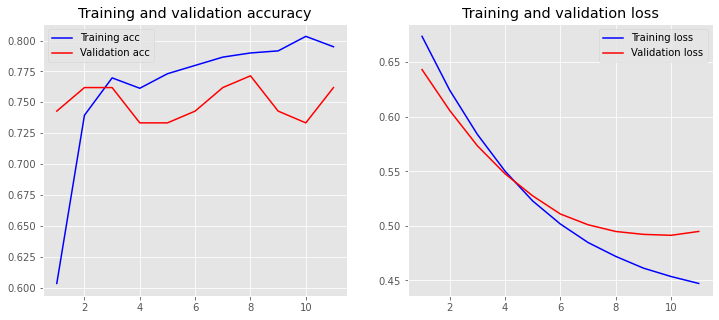

In [32]:
def Keras_Model():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(units = 6,
                  kernel_initializer = 'uniform',
                  input_dim = input_dim)(inputs)
    layer = Dense(units = 2)(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

classifier = Keras_Model()
classifier.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['mse', 'acc'])
nn_it = classifier.fit(X_train, y_train,
                       validation_split=0.15, batch_size = 32,
                       epochs = 100,
                       callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)],
                       shuffle = True)



y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


acc_loss(nn_it)

In [33]:
loss, mse, accuracy = classifier.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, mse, accuracy = classifier.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7914
Testing Accuracy:  0.7333


In [22]:
input_dim

61

$$N_h = \frac{N_s} {(\alpha * (N_i + N_o))}$$

**$N_i$**  = number of input neurons.  
**$N_o$** = number of output neurons.  
**$N_s$** = number of samples in training data set.  
**$\alpha$** = an arbitrary scaling factor usually 2-10.  

In [148]:
round(700/(2*(61+1)),0)

6.0

# Random Forest

In [25]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=2,
                            random_state=1337,
                            criterion="gini",
                            bootstrap=True,
                            max_features=15,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators = 400)

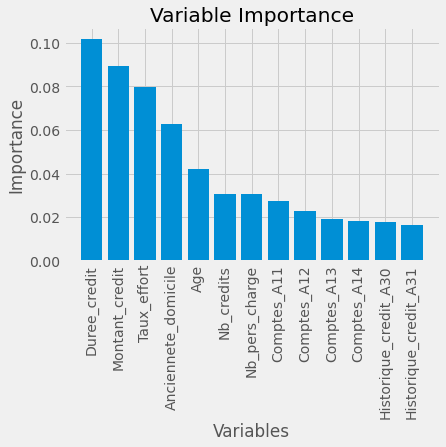

In [51]:
rf.fit(X_train,y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
predictions_prob = rf.predict_proba(X_test)

# Get numerical feature importances
importances = sorted(list(rf.feature_importances_),reverse=True)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values[:13], importances[:13], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:13], features_list[:13], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variables'); plt.title('Variable Importance');

In [52]:
y_pred = rf.predict(X_test)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[181  29]
 [ 45  45]]


# Regression Logistique

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

In [70]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(score)

0.73


In [58]:
y_pred = rf.predict(X_test)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[181  29]
 [ 45  45]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       210
           1       0.61      0.50      0.55        90

    accuracy                           0.75       300
   macro avg       0.70      0.68      0.69       300
weighted avg       0.74      0.75      0.75       300



# Support Vector Classifier

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

In [59]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='poly', probability=True)
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [69]:
y_pred = svclassifier.predict(X_test)

score = svclassifier.score(X_test, y_test)
print(score)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

0.7266666666666667
[[206   4]
 [ 78  12]]
              precision    recall  f1-score   support

           0       0.73      0.98      0.83       210
           1       0.75      0.13      0.23        90

    accuracy                           0.73       300
   macro avg       0.74      0.56      0.53       300
weighted avg       0.73      0.73      0.65       300



# XGBoost 

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

In [95]:
from xgboost import XGBClassifier
import xgboost as xgb

print(np.shape(X_train), np.shape(X_test))

xg_model = XGBClassifier(n_estimators=500,
                        learning_rate=0.075,
                        max_depth = 200,
                        min_child_weight = 1,
                        seed = 1337,
                        objective = 'binary:logistic')
xg_model.fit(X_train, y_train, early_stopping_rounds=10,
             eval_set=[(X_test, y_test)], verbose=False)

(700, 61) (300, 61)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.075, max_delta_step=0, max_depth=200,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1337, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1337, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

16


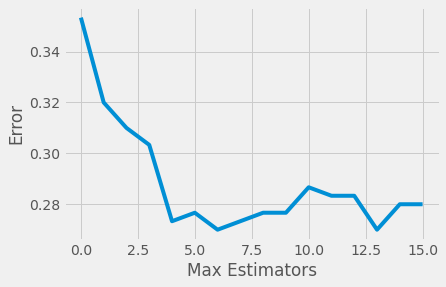

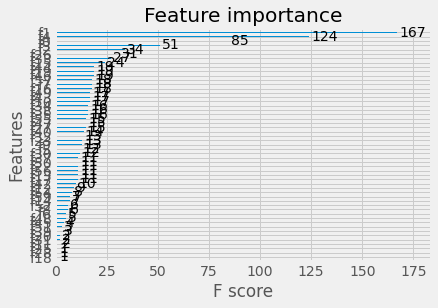

In [96]:
max_estimators = len(xg_model.evals_result()['validation_0']['error'])
print(max_estimators)
max_estim_rmse = pd.DataFrame(xg_model.evals_result()['validation_0']['error'], columns=['error'])
plt.plot(max_estim_rmse)
plt.ylabel("Error")
plt.xlabel("Max Estimators")
xgb.plot_importance(xg_model)

In [97]:
y_pred = xg_model.predict(X_test)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[172  38]
 [ 43  47]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       210
           1       0.55      0.52      0.54        90

    accuracy                           0.73       300
   macro avg       0.68      0.67      0.67       300
weighted avg       0.73      0.73      0.73       300



# Decision Trees

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

In [98]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [100]:
y_pred = clf.predict(X_test)

score = svclassifier.score(X_test, y_test)
print(score)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

0.7266666666666667
[[144  66]
 [ 45  45]]
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       210
           1       0.41      0.50      0.45        90

    accuracy                           0.63       300
   macro avg       0.58      0.59      0.58       300
weighted avg       0.65      0.63      0.64       300

